# Visualize the results of NTP on SSL models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from copy import deepcopy
import numpy as np
import sys
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
from pathlib import Path
from importlib import import_module
import os

# Path to the parent directory
parent_directory_path = Path.cwd().parent  # Adjust this path as necessary

# Iterate through each child directory in the parent directory
for child in parent_directory_path.iterdir():
    if child.is_dir():  # Make sure it's a directory
        sys.path.append(str(child))

# For each child directory in the parent directory
for child in parent_directory_path.iterdir():
    if child.is_dir():  # Make sure it's a directory
        # List all .py files in the directory
        for file in child.glob('*.py'):
            # Import the module
            # Note: os.path.splitext(file.name)[0] gets the module name without the .py extension
            module_name = os.path.splitext(file.name)[0]
            imported_module = import_module(module_name)
            print(f"Imported {module_name} from {child.name}")

Imported pretrain_models from train
Imported ssl_model_pruning from prune
Imported ntl-prune from prune
Imported admm from prune
Imported prune_encoder from prune
Imported pruner from prune
Imported pruning_utils from prune
Imported __init__ from prune
Imported admm_encoder from prune
Imported prune_model from prune
Imported syn from utils
Imported similarity from utils


ImportError: attempted relative import with no known parent package

In [3]:
from models.encoders import ResNetEncoder, ResNetClassifier
from prune.pruner import load_base_model
from metrics.LogME import LogME
from metrics.SFDA import SFDA_Score

In [4]:
# Load the backbone model
num_classes = 10
model = torchvision.models.resnet50(pretrained=True)
# change the output layer to 10 classes (for digits dataset)
model.fc = nn.Linear(2048, num_classes)

/home/ruyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset

def get_cifar_dataloader(ratio=1.0):
    """
    Get the CIFAR10 dataloader
    """
    # Data loading code for cifar10 
    train_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        ),
    ])

    val_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        ),
    ])

    train_dataset = datasets.CIFAR10(
        root="../../data/",
        train=True,
        download=True,
        transform=train_transform,
    )

    # Define the size of the subset
    subset_size = int(len(train_dataset) * ratio)
    print(f"Using the sample size of {subset_size}.")

    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    val_dataset = datasets.CIFAR10(
        root="../../data/",
        train=False,
        download=True,
        transform=val_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=64,
        shuffle=True,
        num_workers=10,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=10,
    )

    return train_loader, val_loader

def get_stl_dataloader(ratio=0.1):
    """
    Get the STL10 dataloader
    """
    # Data loading code for STL10 
    train_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.transforms.ToTensor(),
    ])

    val_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.ToTensor(),
    ])

    train_dataset = datasets.STL10(
        root="../../data/",
        split='train',
        download=True,
        transform=train_transform,
    )

    # Define the size of the subset
    subset_size = int(len(train_dataset)*ratio)
    print(f"Using sample size of {subset_size}.")
                      
    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    val_dataset = datasets.STL10(
        root="../../data/",
        split='test',
        download=True,
        transform=val_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=64,
        shuffle=True,
        num_workers=10,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=10,
    )

    return train_loader, val_loader

In [6]:
source_domain = 'cifar10'
target_domain = 'stl'

In [7]:
ratio = 1.0
if source_domain == 'cifar10':
    source_trainloader, source_testloader = get_cifar_dataloader(ratio)
elif source_domain == 'stl':
    source_trainloader, source_testloader = get_stl_dataloader(ratio)

if target_domain == 'cifar10':
    target_trainloader, target_testloader = get_cifar_dataloader(ratio)
elif target_domain == 'stl':
    target_trainloader, target_testloader = get_stl_dataloader(ratio)

Files already downloaded and verified
Using the sample size of 50000.
Files already downloaded and verified
Files already downloaded and verified
Using sample size of 5000.
Files already downloaded and verified


In [12]:
torch.cuda.empty_cache()

In [8]:
arch = 'resnet50'
model_name = 'simclr'
seed=3
encoder_path = f'../../saved_models/{arch}/{model_name}/admm-lda/{source_domain}_to_{target_domain}/{seed}/admm_encoder.pth'
classifier_path = f'../../saved_models/{arch}/{model_name}/admm-lda/{source_domain}_to_{target_domain}/{seed}/admm_source_classifier.pth'
mask_path  = f'../../saved_models/{arch}/{model_name}/admm-lda/{source_domain}_to_{target_domain}/{seed}/admm_mask.pth'

mask_dict = torch.load(mask_path)
resnet_encoder = torch.load(encoder_path)
resnet_classifier = torch.load(classifier_path)
# clean gpu cache 


In [88]:
# Get the pretrained encoder
arch = 'resnet50'
model_name = 'moco-v1'
seed=2
encoder_path = f'../../saved_models/ssl_models/{arch}-{model_name}/{source_domain}_to_{target_domain}/encoder.pth'
classifier_path = f'../../saved_models/ssl_models/{arch}-{model_name}/{source_domain}_to_{target_domain}/classifier.pth'
mask_path  = f'../../saved_models/ssl_models/{arch}-{model_name}/{source_domain}_to_{target_domain}/mask.pth'

resnet_encoder = torch.load(encoder_path)
resnet_classifier = torch.load(classifier_path)

mask_dict ={}
for name, param in resnet_encoder.named_parameters():
    mask_dict[name] = torch.ones_like(param)

In [10]:
total_params = 0
total_nonzero_params = 0
for name, param in resnet_encoder.named_parameters():
    total_params += param.numel()
    if name in mask_dict:
        total_nonzero_params += torch.sum(mask_dict[name]).item()
print(f"Model sparsity: {1-total_nonzero_params/total_params}")

Model sparsity: 0.7540766197885036


## Plot the latent feature space

In [11]:
# The feature space of source domain 
source_features = []
source_labels = []
for i, (inputs, labels) in enumerate(source_testloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    source_features.append(features)
    source_labels.append(labels)
    if i > 10:
        break

source_features = torch.cat(source_features, dim=0)
source_labels = torch.cat(source_labels, dim=0)
print(f"Source features: {source_features.shape}, Source labels: {source_labels.shape}")

n_samples = source_features.shape[0]
source_features = source_features.cpu().detach().numpy().reshape(n_samples, -1)
source_labels = source_labels.cpu().detach().numpy()

Source features: torch.Size([768, 2048, 1, 1]), Source labels: torch.Size([768])


In [13]:
# The feature space of target domain
target_features = []
target_labels = []
for i, (inputs, labels) in enumerate(target_testloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    target_features.append(features)
    target_labels.append(labels)
    if i > 10:
        break
target_features = torch.cat(target_features, dim=0)
target_labels = torch.cat(target_labels, dim=0)
print(f"Target features: {target_features.shape}, Target labels: {target_labels.shape}")

Target features: torch.Size([768, 2048, 1, 1]), Target labels: torch.Size([768])


In [14]:
target_features = target_features.cpu().detach().numpy().reshape(n_samples, -1)
target_labels = target_labels.cpu().detach().numpy()

/tmp/ipykernel_5786/1553480258.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


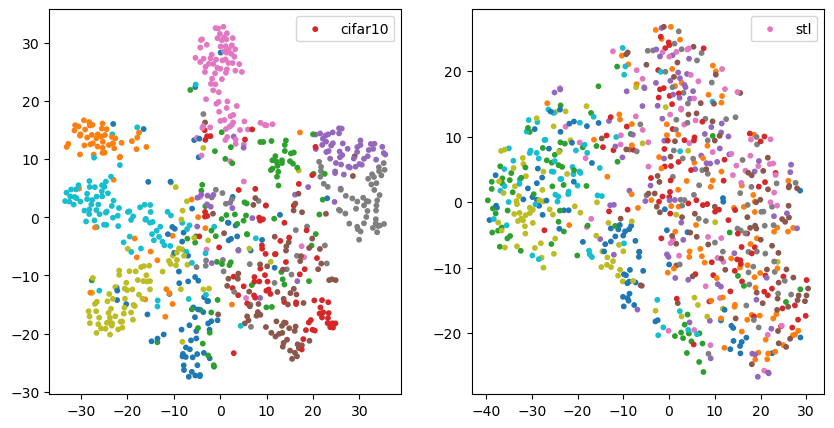

In [15]:
## Visualize the feature space of both domains using TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

source_features_transformed = tsne.fit_transform(source_features)
target_features_transformed = tsne.fit_transform(target_features)
plt.subplots(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(source_features_transformed[:, 0], source_features_transformed[:, 1], c=source_labels, cmap='tab10', s=10, label=source_domain)
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(target_features_transformed[:, 0], target_features_transformed[:, 1], c=target_labels,  cmap='tab10', s=10,  label=target_domain)
plt.legend()
plt.show()

In [16]:
# The feature space of source domain 
logme = LogME(regression=False)
score = logme.fit(np.array(source_features), np.array(source_labels))
score

3.747125251263742

In [17]:
# The feature space of source domain 
logme = LogME(regression=False)
score = logme.fit(np.array(target_features), np.array(target_labels))
score


1.259028121354834

In [18]:
# The feature space of source domain 
sfda_score = SFDA_Score(source_features, source_labels)
sfda_score

Shrinkage: 0.012644228950929337
Shrinkage: 0.012644228950929337


0.9831992226594432

In [19]:
# The feature space of source domain 
sfda_score = SFDA_Score(target_features, target_labels)
sfda_score

Shrinkage: 0.7505266498426999
Shrinkage: 0.7505266498426999


0.3901708385175482

: 